In [1]:
%run "00-common"

import sklearn as sk
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

import sklearn.model_selection as cv
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, VotingClassifier
import sklearn.ensemble as en
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

df = pd.read_csv('../feature_selection.csv')
df.head()

,koi_period,koi_period_err1,koi_period_err2,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_duration_err1,koi_duration_err2,koi_depth,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,dec,koi_disposition
0,101.110701,0.000953,-0.000953,0.008060,-0.008060,0.0460,0.2100,-0.2100,878.1,1.61,0.10,-0.08,229.0,0.65,0.14,-0.11,24.1,4133.0,74.0,-82.0,0.023,-0.033,0.561,0.033,41.452209,1
1,4.800654,0.000004,-0.000004,0.000745,-0.000745,0.7850,0.0550,-0.0550,15304.0,16.91,6.01,-2.00,1347.0,778.45,793.72,-255.78,298.0,6715.0,161.0,-241.0,0.056,-0.224,1.241,0.441,38.999008,0
2,39.593105,0.000615,-0.000615,0.014000,-0.014000,0.0044,0.5980,-0.5980,156.6,1.22,0.51,-0.11,546.0,21.06,26.65,-6.05,5.7,6046.0,172.0,-218.0,0.044,-0.298,0.972,0.411,41.659611,0
3,31.158825,0.000057,-0.000057,0.001380,-0.001380,0.0290,0.0504,-0.0504,959.0,3.56,0.57,-0.46,639.0,39.46,17.49,-11.96,73.6,5951.0,107.0,-119.0,0.120,-0.120,1.155,0.184,38.710232,1
4,613.829050,0.032600,-0.032600,0.031900,-0.031900,0.2616,1.4000,-1.4000,148.2,2.85,1.25,-1.41,307.0,2.10,2.78,-1.62,10.2,5636.0,173.0,-148.0,0.459,-0.224,2.357,1.027,43.824032,0


In [2]:
y = df['koi_disposition']
X = df.drop('koi_disposition', axis=1)
(X_train, X_test, y_train, y_test) = cv.train_test_split(X, y, test_size=.3, stratify=y, random_state=1)

In [3]:
nb = Pipeline(steps=[
    ('Scaler', preprocessing.PowerTransformer() ),
    ('NCA', NeighborhoodComponentsAnalysis(random_state=1)),
    ('NB', GaussianNB())])
knn = Pipeline(steps=[
    ('Scaler', preprocessing.StandardScaler()),
    ('KNN', KNeighborsClassifier(n_neighbors=7, weights='distance')),
     ])
dt = DecisionTreeClassifier(criterion='gini', max_depth=5)

svm = Pipeline(steps=[
    ('Scaler', preprocessing.MinMaxScaler(feature_range=(-1, 1))),
    ('SVM', SVC(kernel='linear', C=1e5)),
])

voting = VotingClassifier(estimators=[('nb', nb), ('knn', knn), ('dt', dt)], voting='hard')

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200, max_features=0.9)

rf_params = {'bootstrap': False,
 'max_depth': 50,
 'max_features': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 100}
rf = en.RandomForestClassifier(**rf_params)

abc = en.AdaBoostClassifier(learning_rate=0.5, n_estimators=60)

classifiers = {
    'nb': nb,
    'knn': knn,
    'dt': dt,
    'svm': svm,
    'voting': voting,
    'bag': bag,
    'rf': rf,
    'ada': abc,
}

In [4]:
for (method, cf) in classifiers.items():
    print('Fitting', method)
    cf.fit(X_train, y_train)

Fitting nb
Fitting knn
Fitting dt
Fitting svm
Fitting voting
Fitting bag
Fitting rf
Fitting ada


In [6]:
import pickle

with open('pickles/all-trained.pkl', 'wb') as out:
    pickle.dump(classifiers, out)

In [8]:
dd = y_test.to_frame()

for (method, cf) in classifiers.items():
    print('Running', method)
    pred = cf.predict(X_test)
    dd[method] = pred

Running nb
Running knn
Running dt
Running svm
Running voting
Running bag
Running rf
Running ada


In [9]:
y_test

940     0
1633    1
1632    0
187     1
941     0
       ..
1739    1
1223    0
1459    0
285     0
792     0
Name: koi_disposition, Length: 600, dtype: int64

In [10]:
dd

,koi_disposition,nb,knn,dt,svm,voting,bag,rf,ada
940,0,0,0,0,0,0,0,0,0
1633,1,1,1,1,1,1,1,1,1
1632,0,0,1,0,0,0,0,0,0
187,1,1,1,1,1,1,1,1,1
941,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1739,1,1,1,1,1,1,1,1,1
1223,0,0,0,0,0,0,0,0,0
1459,0,0,0,0,0,0,0,0,0
285,0,0,0,0,0,0,0,0,0


In [11]:
ddd = pd.DataFrame()
for c in dd.columns[1:]:
    ddd[c] = dd[c] == dd.koi_disposition

In [13]:
from statsmodels.stats.contingency_tables import mcnemar

n = len(ddd.columns)
pvalues = np.ones(shape=(n,n))
statistics = np.zeros(shape=(n,n))

n = len(ddd.columns)
for i in range(n):
    for j in range(i+1, n):
        tab = pd.crosstab(ddd.iloc[:,i], ddd.iloc[:,j])
        res = mcnemar(tab)
        pvalues[i][j] = res.pvalue
        pvalues[j][i] = res.pvalue
        statistics[i][j] = res.statistic
        statistics[j][i] = res.statistic
        
        tab.to_latex('../tables/crosstab_{}_{}.tex'.format(i, j))

In [14]:
pvalues

array([[1.00000000e+00, 4.21523344e-01, 8.55453850e-03, 4.27240503e-03,
        1.64149134e-03, 5.77837200e-05, 1.01477123e-04, 8.83755633e-05],
       [4.21523344e-01, 1.00000000e+00, 3.12978601e-04, 1.76309230e-04,
        2.24755940e-05, 2.18232797e-06, 2.18232797e-06, 3.39716682e-06],
       [8.55453850e-03, 3.12978601e-04, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 9.31396484e-02, 9.31396484e-02, 2.91215237e-01],
       [4.27240503e-03, 1.76309230e-04, 1.00000000e+00, 1.00000000e+00,
        8.77614329e-01, 3.01995613e-01, 3.01995613e-01, 3.36783635e-01],
       [1.64149134e-03, 2.24755940e-05, 1.00000000e+00, 8.77614329e-01,
        1.00000000e+00, 1.10184165e-01, 1.21449485e-01, 2.22052820e-01],
       [5.77837200e-05, 2.18232797e-06, 9.31396484e-02, 3.01995613e-01,
        1.10184165e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.01477123e-04, 2.18232797e-06, 9.31396484e-02, 3.01995613e-01,
        1.21449485e-01, 1.00000000e+00, 1.00000000e+00, 1.

In [15]:
statistics

array([[ 0., 45., 24., 21., 12., 15., 17., 15.],
       [45.,  0., 22., 21., 11., 17., 17., 17.],
       [24., 22.,  0., 24., 12.,  7.,  7., 18.],
       [21., 21., 24.,  0., 20., 19., 19., 16.],
       [12., 11., 12., 20.,  0., 11., 12., 17.],
       [15., 17.,  7., 19., 11.,  0.,  9., 16.],
       [17., 17.,  7., 19., 12.,  9.,  0., 19.],
       [15., 17., 18., 16., 17., 16., 19.,  0.]])

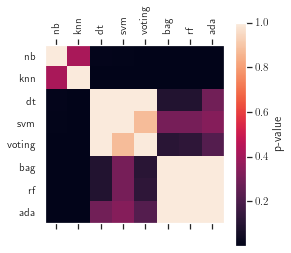

In [16]:
plt.matshow(pvalues)
plt.colorbar(label='p-value')
plt.grid(b=None)
plt.xticks(np.arange(n), ddd.columns, rotation=90)
plt.yticks(np.arange(n), ddd.columns, rotation=0)
plt.savefig('../figures/mcnemar_pvalue.pdf')

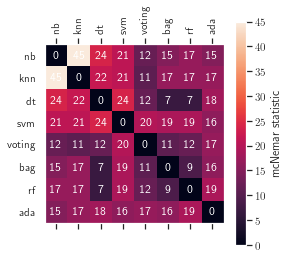

In [17]:
#fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
plt.matshow(statistics)

plt.colorbar(label='mcNemar statistic')
plt.grid(b=None)
plt.xticks(np.arange(n), ddd.columns, rotation=90)
plt.yticks(np.arange(n), ddd.columns, rotation=0)

for (i, j), z in np.ndenumerate(statistics):
    plt.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', color = 'white', weight='bold')
            #bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.savefig('../figures/mcnemar.pdf')

In [18]:
pvalues

array([[1.00000000e+00, 4.21523344e-01, 8.55453850e-03, 4.27240503e-03,
        1.64149134e-03, 5.77837200e-05, 1.01477123e-04, 8.83755633e-05],
       [4.21523344e-01, 1.00000000e+00, 3.12978601e-04, 1.76309230e-04,
        2.24755940e-05, 2.18232797e-06, 2.18232797e-06, 3.39716682e-06],
       [8.55453850e-03, 3.12978601e-04, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 9.31396484e-02, 9.31396484e-02, 2.91215237e-01],
       [4.27240503e-03, 1.76309230e-04, 1.00000000e+00, 1.00000000e+00,
        8.77614329e-01, 3.01995613e-01, 3.01995613e-01, 3.36783635e-01],
       [1.64149134e-03, 2.24755940e-05, 1.00000000e+00, 8.77614329e-01,
        1.00000000e+00, 1.10184165e-01, 1.21449485e-01, 2.22052820e-01],
       [5.77837200e-05, 2.18232797e-06, 9.31396484e-02, 3.01995613e-01,
        1.10184165e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.01477123e-04, 2.18232797e-06, 9.31396484e-02, 3.01995613e-01,
        1.21449485e-01, 1.00000000e+00, 1.00000000e+00, 1.

In [19]:
tbl = pd.DataFrame(pvalues, index=ddd.columns)
tbl.columns = ddd.columns
tbl.to_latex('../tables/mcnemar_pvalues.tex', float_format="%.2f")

tbl = pd.DataFrame(statistics, index=ddd.columns)
tbl.columns = ddd.columns
tbl.to_latex('../tables/mcnemar.tex', float_format="%.0f")

In [24]:
metrics = pd.DataFrame()
    
for (method, cf) in classifiers.items():
    print('Running', method)
    pred = cf.predict(X_test)
    acc = sk.metrics.accuracy_score(y_test, pred)
    f1 = sk.metrics.f1_score(y_test, pred)
    metrics[method] = [acc, f1]

Running nb
Running knn
Running dt
Running svm
Running voting
Running bag
Running rf
Running ada


In [29]:
metrics = metrics.transpose()
metrics.columns = ['Accuracy', 'F1']
metrics

,Accuracy,F1
nb,0.871667,0.813559
knn,0.856667,0.788177
dt,0.910000,0.858639
svm,0.911667,0.865140
voting,0.908333,0.858612
bag,0.925000,0.882507
rf,0.925000,0.881890
ada,0.923333,0.881443


In [30]:
metrics.to_latex('../tables/metrics.tex')

In [ ]:
import pickle

with open('pickles/train-out.pkl', 'wb') as out:
    pickle.dump(dd, out)